<a href="https://colab.research.google.com/github/sanglee/BDS_WS/blob/main/lecture04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Biomedical Data Science Winter School

@author: Sangkyun Lee  (sangkyun@korea.ac.kr)

___ML IV: SVM, Model Selection, Performance Measures___

---

In [ ]:
# A utility function to plot decision boundaries in 2D

from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)]*sum(y == cl),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

---
### Loading the IRIS data

In [ ]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', names= ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Label'])

In [ ]:
df.head()

Sepal Length  Sepal Width  Petal Length  Petal Width        Label
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

In [ ]:
# Prepare data matrix and labels

import numpy as np
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:, [2, 3]].values
y = df.iloc[:, 4].values
enc_y = LabelEncoder()
enc_y.fit(y)
y = enc_y.transform(y)
feature_names = df.columns.values[[2,3]]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)

---
## Support Vector Machine (SVM)

- A linear classifier, invented by V. Vapnik
  - The father of machine learning
  - Cortes, Corinna; Vapnik, Vladimir N., Support-vector networks,  Machine Learning, 20 (3): 273–297 (1995)
- The notion of the "margin" between two class point clouds
  - While **minimizing prediction error**, SVM **maximizes the margin** at the same time
- SVM is hardly overfit, under regular conditions
- SVM can use **kernels**


<img src="https://raw.githubusercontent.com/sanglee/BDS_WS/master/img/03_09.png" width=800>

#### Some details

- Data
 - Input $x^{(i)} \in R^p$, $i=1,2,\dots,n$
 - Label $y^{(i)} \in \{-1,+1\}$, $i=1,2,\dots,n$


- The length of the margin: $\frac{2}{||w||_2}$

- Loss:

$$
\begin{cases}
  w^T x^{(i)} + w_0 \ge 1 & \text{if $y^{(i)} = 1$} \\
  w^T x^{(i)} + w_0 \le -1 & \text{if $y^{(i)} = -1$}
\end{cases}
, i=1,2,\dots, n
$$
This leads to
$$
 y^{(i)} (w^T x^{(i)} + w_0)\ge 1, \;\; i=1,2,\dots,n
$$

#### SVM Training Problem
Soft-margin SVM (quadratic program):

\begin{align*}
 \min_{w,w_0} &\;\; \frac12 \|w\|_2^2 + C \sum_{i=1}^n \xi_i\\
 \text{subject to} &\;\; y^{(i)} (w^T x^{(i)} + w_0) \ge 1 - \xi_i, \;\; i=1,2,\dots,n \\
  &\;\; \xi_i \ge 0
\end{align*}

### SVM in Scikit-Learn

In [ ]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

svm = SVC(kernel='linear', C=10.0)

svm.fit(X_train_std, y_train)           # standardization is recommended for numerical reasons here

plot_decision_regions(X_train_std,           
                      y_train,
                      classifier=svm)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

print('Train accuracy: %f' % accuracy_score(svm.predict(X_train_std), y_train))
print('Test accuracy: %f' % accuracy_score(svm.predict(X_test_std), y_test))

Train accuracy: 0.945205
Test accuracy: 0.977778


### Feature Importance

- Linear models (logistic regression, linear SVM, perceptron, ...)
  - Prediction for an input $x^{(i)}$ is produced by $\hat y^{(i)} = f(w^T x^{(i)})$, where $f$ is some function, e.g., to convert linear output to binary outcome.
  - $w^T x^{(i)} = \sum_{j=1}^p w_j x^{(i)}_j$ 
  - We call $w_1, w_2, \dots, w_p$ as **coefficients**, **weights**, or **learning parameters**
  - In scikit-learn, `<model>.coef_` contains the coefficients
  
- Non-linear models (decision trees, random forest, nonlinear SVM, ...)
  - This type of models provides other ways to measure feature importance
    - DT, RF: `<model>.feature_importances_`
  - In some models, it is not easy to extract feature importance
    - Nonlinear SVM

In [ ]:
svm.coef_

array([[-1.06139348, -1.1489091 ],
       [-0.57330686, -0.57625103],
       [-2.65965384, -4.01574174]])

---
## Nonlinear Classification

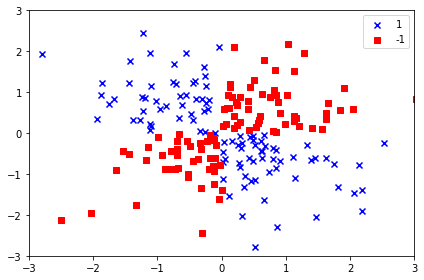

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

---
### Feature Mapping $\phi$

The feature mapping $\phi$ transforms data points into another **representation**

For example, in the following figure,
- Original representation: $(x_1, x_2)$  : **input space**
- New representation: $(z_1, z_2, z_3)$  : **feature space**

$(z_1, z_2, z_3) = (x_1, x_2, x_1^2 + x_2^2)$

The idea: learn an SVM in the feature space where data points are linearly separable!

<img src="https://raw.githubusercontent.com/sanglee/BDS_WS/master/img/03_11.png" width=700>

---
### Kernel trick

What is a good feature mapping $\phi$? It is hard to design a good $\phi$ for a given data set.

Define and use **kernel** instead of $\phi$:

$$
  k(x^{(i)},x^{(j)}) = \langle \phi(x^{(i)}), \phi(x^{(j)}) \rangle
$$

#### Linear Kernel:
$$
  k(x^{(i)},x^{(j)}) = \langle x^{(i)}, x^{(j)} \rangle
$$
- This does no transformation at all.


#### Gaussian RBF Kernel (RBF: Radial Basis Function), a.k.a. Gaussian Kernel:
\begin{align*}
 k(x^{(i)},x^{(j)}) &= \exp\left( -\frac{\|x^{(i)}-x^{(j)}\|_2^2}{2\sigma^2} \right)
 = \exp\left( - \gamma \|x^{(i)}-x^{(j)}\|_2^2 \right)
\end{align*}

- This maps data points into **Reproducing Kernel Hilbert Space (RKHS)**
- The hyper-parameter $\gamma = \frac{1}{2\sigma^2}$ is to be determined by the user.

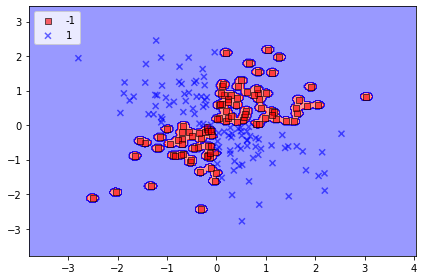

In [ ]:
#
# SVM on XOR data
#
svm = SVC(kernel='rbf', random_state=1, gamma=250, C=10)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
#
# SVM on IRIS data
#

from sklearn.svm import SVC

svm = SVC(kernel='rbf', gamma=0.2, C=1.0)  # gamma=100.0, C=1.0
svm.fit(X_train_std, y_train)

plot_decision_regions(X_train_std, y_train, classifier=svm)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

print('Train accuracy: %f' % accuracy_score(svm.predict(X_train_std), y_train))
print('Test accuracy: %f' % accuracy_score(svm.predict(X_test_std), y_test))

Train accuracy: 0.945205
Test accuracy: 0.977778


---
## Model Selection

### Holdout Method

<img src="https://raw.githubusercontent.com/sanglee/BDS_WS/master/img/06_02.png?raw=true" width=500>

### K-Fold Cross Validation (K-Fold CV)

<img src="https://raw.githubusercontent.com/sanglee/BDS_WS/master/img/06_03.png?raw=true" width=650>

In [ ]:
#
# Wisconsin Breast-Cancer Data Set
#
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                     '/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()

0  1      2      3       4       5        6        7       8   \
0    842302  M  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001   
1    842517  M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869   
2  84300903  M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974   
3  84348301  M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414   
4  84358402  M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980   

        9   ...     22     23      24      25      26      27      28      29  \
0  0.14710  ...  25.38  17.33  184.60  2019.0  0.1622  0.6656  0.7119  0.2654   
1  0.07017  ...  24.99  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860   
2  0.12790  ...  23.57  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430   
3  0.10520  ...  14.91  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575   
4  0.10430  ...  22.54  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625   

       30       31  
0  0.4601  0.11890  
1  0.2750  0.08902  
2  0.3613  0.08758  
3  0.6638  0.17300  
4  0.2364  0.07678  

[5 rows x 32 columns]

In [ ]:
#
# Preprocessing & splitting
#
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])   # M=malignant, B=benign

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

### K-Fold CV

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

C_grid = [0.1, 1, 10]
cv_err = []

for c in C_grid:
    scores = cross_val_score(estimator=LogisticRegression(C=c),
                             X=X_train,
                             y=y_train,
                             cv=5,
                             scoring='accuracy',
                             n_jobs=-1)  # no. cpu cores to use. -1 all cores
    print('C = %f' % c)
    print('CV accuracy scores:\n %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    print('--------------------------------------------------------------------')
    cv_err.append(np.mean(scores))
    
best_idx = np.argmax(cv_err)
print(best_idx)
best_C = C_grid[best_idx]

print('Best C due to CV: %f' % best_C)

C = 0.100000
CV accuracy scores:
 [0.87912088 0.87912088 0.95604396 0.96703297 0.95604396]
CV accuracy: 0.927 +/- 0.040
--------------------------------------------------------------------
C = 1.000000
CV accuracy scores:
 [0.91208791 0.92307692 0.97802198 0.96703297 0.95604396]
CV accuracy: 0.947 +/- 0.025
--------------------------------------------------------------------
C = 10.000000
CV accuracy scores:
 [0.87912088 0.92307692 0.97802198 0.97802198 0.95604396]
CV accuracy: 0.943 +/- 0.038
--------------------------------------------------------------------
1
Best C due to CV: 1.000000


---
## Performance Evaluation


### Confusion Matrix
<img src="https://raw.githubusercontent.com/sanglee/BDS_WS/master/img/06_08.png?raw=true" width=300>

In [ ]:
from sklearn.metrics import confusion_matrix

print('M, B are transformed into: ' + str(le.transform(['M', 'B'])))
print('Labels count: (1,0) = (%d, %d)' % (np.sum(y_test==1), np.sum(y_test==0)))
print()

svm = SVC(gamma=0.0001, C=10)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
#confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=le.transform(['M', 'B']))
print('Confusion matrix:\n', confmat)

M, B are transformed into: [1 0]
Labels count: (1,0) = (42, 72)

Confusion matrix:
 [[38  4]
 [ 1 71]]


**Q. Does the shape of the confusion matrix look correct?**

### Prediction Performance Metrics

#### Accuracy (ACC):
$$
   ACC = \frac{\text{Correct}}{\text{ALL}} = \frac{TP+TN}{ALL} = 1 - ERR
$$

---

#### Sensitivity, Hit rate, or True positive rate (TPR) = Recall (of the positive class)
$$
 TPR = \frac{TP}{Actual \; P} = \frac{TP}{TP+FN}
$$
#### Specificity, Selectivity or True Negative Rate (TNR) = Recall of the negative class
$$
 TNR = \frac{TN}{Actual \; N} = \frac{TN}{TN+FP} = 1-FPR
$$

#### False positive rate (FPR):
$$
 FPR = \frac{FP}{Actual \; N} = \frac{FP}{FP+TN} = 1-TNR
$$

---

#### Precision (PRE):
$$
  PRE = \frac{TP}{Predicted \; P} = \frac{TP}{TP + FP}
$$
#### Recall (REC)
$$
  REC = TPR = \frac{TP}{Actual \; P} = \frac{TP}{TP+FN}
$$
#### False Discovery Rate (FDR)
$$
  FDR = \frac{FP}{Predicted \; P} = \frac{FP}{TP + FP} = 1 - PRE
$$



#### F1 score
The harmonic mean of precision and recall
$$
  F1 = 2 \frac{PRE \times REC}{PRE + REC}
$$

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, pos_label=1))
print('Recall of Pos(Sensitivity): %.3f' % recall_score(y_true=y_test, y_pred=y_pred, pos_label=1))
print('Recall of Neg(Specificity): %.3f' % recall_score(y_true=y_test, y_pred=y_pred, pos_label=0))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.974
Recall of Pos(Sensitivity): 0.905
Recall of Neg(Specificity): 0.986
F1: 0.938


In [ ]:
from sklearn.metrics import classification_report

print(le.transform(['M', 'B']))
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=['B', 'M']))

[1 0]
              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



---

## ROC (Receiver-Operator Characteristic) Curve
### AUC: Area Under the ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

lr = LogisticRegression(solver='liblinear', C=100)
probas = lr.fit(X_train, y_train).predict_proba(X_train)

fpr, tpr, thresholds = roc_curve(y_train, probas[:, 1], pos_label=1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,
             lw=1,
             label='area = %0.2e' % (roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

---
## Summary

__Supervised Learning: Classification__


__SVM__
- Maximal margin linear classifier
- Can be applied to not linearly separable problems, using kernels
  - Linear kernel
  - Gaussian RBF kernel (hyperparameter: $\gamma$)
  - Kernels can be defined on more general objects: DNA sequences, chemical compounds, etc.
- Hardly overfit: good for practical use

__Model Selection__
- Holdout method
- K-Fold CV
  - CV on training data: for model selection, tuning hyperparameters
  - Double CV is possible:
      - External CV: estimate test error
      - Internal CV: model selection
      - Caveat: eventually we do see all data, and therefore external CV estimate is not a good estimate of the future error compared to the case of using a separate test data. Therefore, it is recommended to clearly state how your estiamtes have been created.

__Performance Metrics__
- Precision & recall
  - Most frequently use in ML
  - F1 score: 0~1
- ROC
  - AUC score: 0~1